# BuzzFeed Headline Exploratory Data Analysis

In this notebook we're going to explore what exactly makes a BuzzFeed headline and the tricks they use to grab your attention.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# matplotlib.style.use('fivethirtyeight')
sns.set_style('ticks')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

colors = ['#006ba6', '#0496ff', '#ffbc42', '#d81159', '#8f2d56', '#41ead4', '#ff206e']
sns.color_palette(colors)
sns.set_palette(colors)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from langdetect import detect
from wordcloud import WordCloud
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

stop_words = stopwords.words('english')

%config InlineBackend.figure_format = 'retina'
pd.set_option("display.max_rows", None)


print('Setup Complete.')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jordansamek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jordansamek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Setup Complete.


/Users/jordansamek/opt/miniconda3/envs/baseline_env/lib/python3.7/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
data = pd.read_csv('../data/buzzfeed_headlines.csv')
print(data.shape)

# let's shuffle the dataset so everything is mixed together appropriately

data = data.sample(frac=1).reset_index().drop('index', axis=1)
data.head()

(380, 3)


,content,description,title
0,"""Last time Queensland went through mandatory i...","""I'm quitting a job that earns me roughly $140...","In The Wake Of ""The Great Resignation"", Aussie..."
1,"""I'm not a superstitious man at all, but this ...",Creepy stories just in time for spooky season....,People Are Sharing The Most Paranormal Thing T...
2,Patrick Mcmullan / Patrick McMullan via Getty ...,Here we go!View Entire Post ›,15 Celebrity Couples That Were So Unexpected T...
3,YOUNGKYU PARK / Netflix\r\nThe bunk beds symbo...,It was originally meant to be a movie.View Ent...,"19 ""Squid Game"" Behind-The-Scenes Facts That A..."
4,"Nickelodeon, Rich Fury / Getty Images\r\nDanie...","Yip, yip, Appa!View Entire Post ›",Netflix Have Announced Who They've Cast For Un...


## Exploring our Text Analytics

Diving into the bits'n'pieces of the format the headlines are in and what they're comprised of.

For simpler pre-processing, we'll convert the `title` column text into lowercase first.

In [3]:
def lower_title(text):
    text = str(text).lower()
    return text

data['title'] = data['title'].apply(lower_title)

data.head()

,content,description,title
0,"""Last time Queensland went through mandatory i...","""I'm quitting a job that earns me roughly $140...","in the wake of ""the great resignation"", aussie..."
1,"""I'm not a superstitious man at all, but this ...",Creepy stories just in time for spooky season....,people are sharing the most paranormal thing t...
2,Patrick Mcmullan / Patrick McMullan via Getty ...,Here we go!View Entire Post ›,15 celebrity couples that were so unexpected t...
3,YOUNGKYU PARK / Netflix\r\nThe bunk beds symbo...,It was originally meant to be a movie.View Ent...,"19 ""squid game"" behind-the-scenes facts that a..."
4,"Nickelodeon, Rich Fury / Getty Images\r\nDanie...","Yip, yip, Appa!View Entire Post ›",netflix have announced who they've cast for un...


Let's see how long each title is, on a character-based level, and maybe what the average title length is:

In [4]:
data['title_len'] = data['title'].apply(len)
data.sample(4)

,content,description,title,title_len
42,"SO, TELL ME ALL ABOUT YOUR FAVORITE FOREIGN MO...",Drop your recommendations here!View Entire Post ›,tell me about your favorite foreign film on ne...,51
70,"Australians love drinking goon, but does the r...","Australians love drinking goon, but does the r...",are these food customs purely australian or do...,83
171,"Gotham / GC Images\r\n""I said, 'Well, when the...",Congratulations!View Entire Post ›,kourtney kardashian and travis barker revealed...,103
89,Keep up with the latest daily buzz with the Bu...,Yippee-ki-yay!View Entire Post ›,harry and sally? john mclaine and holly? this ...,101


In [5]:
data['title_len'].describe()

count    380.000000
mean      87.871053
std       24.656836
min       31.000000
25%       69.000000
50%       86.000000
75%      104.000000
max      160.000000
Name: title_len, dtype: float64

Taking a look at what each title's length looks like, starting from the minimum length to the max.

In [6]:
data.groupby(['title_len'], as_index=False)['title'].max()

,title_len,title
0,31,【速報】hpvワクチン、積極的勧奨の再開を了承 厚労省の審議会
1,35,what's your nightmare period story?
2,38,トランスジェンダーは婦人科を受診しちゃいけないの？ 当事者や医師に聞いてみた
3,39,"how would you die on ""game of thrones?"""
4,42,these random questions reveal if you floss
5,43,自民党「影の幹事長」がdappiへの関与を否定。群馬の村で見えた“親族のつながり“とは
6,47,17 actors who i'm convinced could play any role
7,48,rate these creamy foods and we'll guess your age
8,49,36 products that might help solve your sleep woes
9,50,these 90s rom-coms will 100% make your life be...


We should probably remove the 3 titles that aren't English, just for the sake of consistency of our values that we'll eventually be processing and putting into our ML model. We'll make use of the handy library `langdetect` to easily detect and extract which headlines aren't in English.

In [7]:
def detect_lang(txt):
    try:
        return detect(txt)
    except:
        return np.nan
    
data['language'] = data.title.apply(detect_lang)

In [8]:
data = data[data.language == "en"]
data.groupby(['title_len'], as_index=False)['title'].max()

,title_len,title
0,35,what's your nightmare period story?
1,38,just 34 very nice things for your home
2,39,"how would you die on ""game of thrones?"""
3,42,these random questions reveal if you floss
4,47,17 actors who i'm convinced could play any role
5,48,rate these creamy foods and we'll guess your age
6,49,36 products that might help solve your sleep woes
7,50,these 90s rom-coms will 100% make your life be...
8,51,these 20 high fashion dogs dress better than y...
9,52,what’s it like to have never been in a relatio...


In [9]:
data = data.drop('language', axis=1)

In [10]:
data.head()

,content,description,title,title_len
0,"""Last time Queensland went through mandatory i...","""I'm quitting a job that earns me roughly $140...","in the wake of ""the great resignation"", aussie...",89
1,"""I'm not a superstitious man at all, but this ...",Creepy stories just in time for spooky season....,people are sharing the most paranormal thing t...,114
2,Patrick Mcmullan / Patrick McMullan via Getty ...,Here we go!View Entire Post ›,15 celebrity couples that were so unexpected t...,75
3,YOUNGKYU PARK / Netflix\r\nThe bunk beds symbo...,It was originally meant to be a movie.View Ent...,"19 ""squid game"" behind-the-scenes facts that a...",66
4,"Nickelodeon, Rich Fury / Getty Images\r\nDanie...","Yip, yip, Appa!View Entire Post ›",netflix have announced who they've cast for un...,145


Before cleaning our `title` column to be put into an ML pipeline, let's just do some basic text analytics to get a sense of what each title consists of.

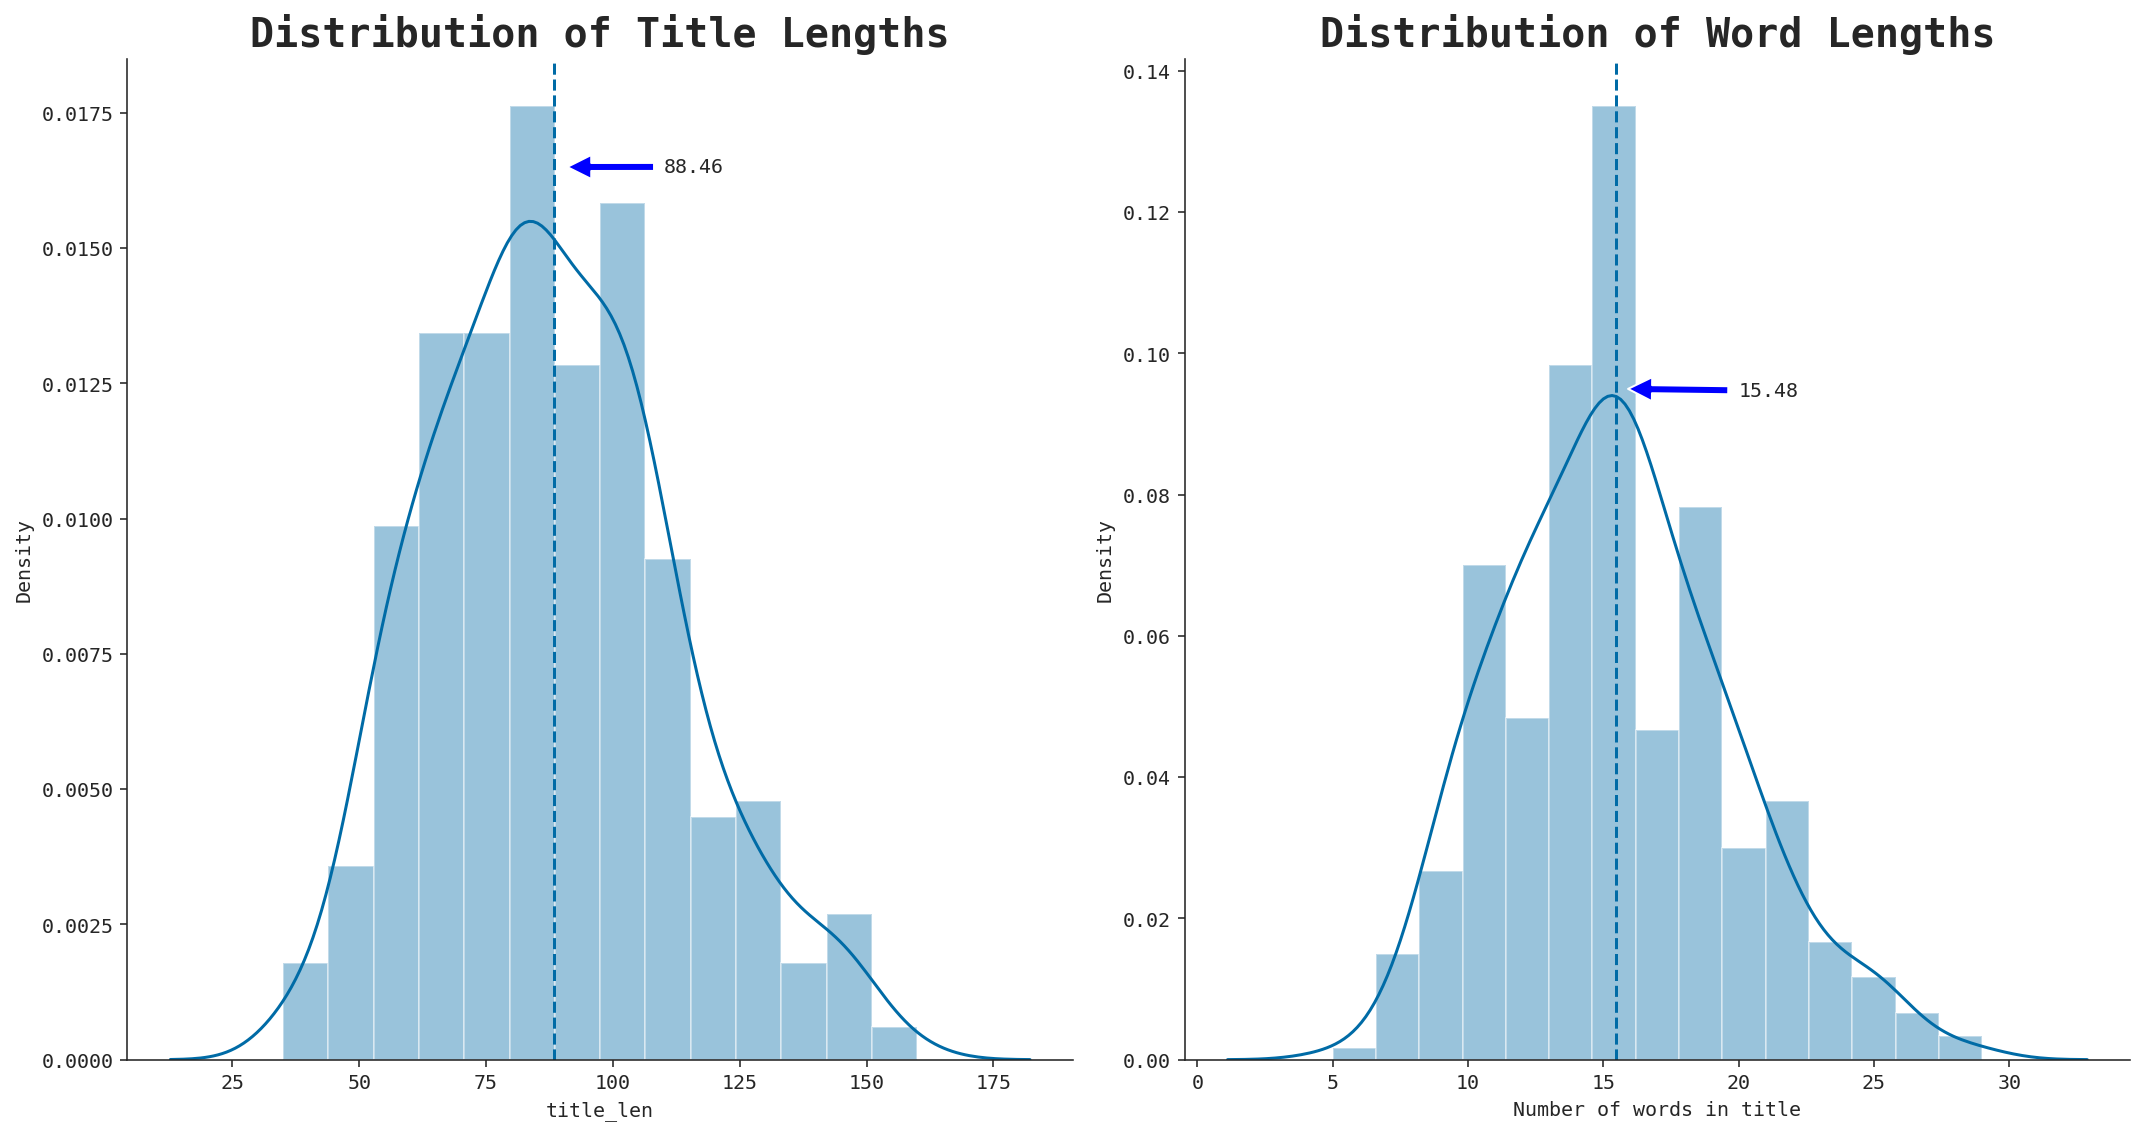

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

plt.subplot(1, 2, 1)
sns.distplot(data['title_len']).set_title('Distribution of Title Lengths', fontsize=20, fontweight='bold')
plt.axvline(np.array(data['title_len'].mean()), ls='dashed')
plt.annotate(round(data['title_len'].mean(),2), xy=(90, 0.0165), xycoords='data', xytext=(110, 0.0164),
             arrowprops=dict(facecolor='blue', shrink=0.05))


title_word_len = data['title'].str.split().map(lambda x: len(x))
word_len_mean = round(title_word_len.mean(), 2)

plt.subplot(1, 2, 2)
sns.distplot(title_word_len).set_title('Distribution of Word Lengths', fontsize=20, fontweight='bold')
plt.axvline(word_len_mean, ls='dashed')
plt.annotate(word_len_mean, xy=(15.7, 0.095), xycoords='data', xytext=(20, 0.094),
             arrowprops=dict(facecolor='blue', shrink=0.05))
plt.xlabel("Number of words in title")

# ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
# ax.set_ylabel('')

plt.tight_layout()
plt.show();

In [13]:
min_title_words = data.title.str.split().map(lambda x: len(x)).min()
max_title_words = data.title.str.split().map(lambda x: len(x)).max()

print(f"The minimum amount of words in our titles is {min_title_words}")
print(f"The maxmimu amount of words in our titles is {max_title_words}")

The minimum amount of words in our titles is 5
The maxmimu amount of words in our titles is 29


If anyone has ever seen any sort of clickbait headlines (which BuzzFeed apparently denies their headlines are clickbait), they've most likely noticed it probably has an odd number thrown in there like "27 Things You Shouldn't Do on a First Date!!" to grab your attention. This type of headline works in many different ways, but one major way is because we humans love lists, especially numbered lists. So let's check out how many headlines of BuzzFeed's contain numbers in them:

In [14]:
num_in_headline_count = 0
no_num_headline_count = 0
for line in data.title:
    if bool(re.search('\d+', line)) == True:
        num_in_headline_count += 1
    else:
        no_num_headline_count += 1
    

<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
/var/folders/xs/d1td623j4l5_3s9p262jr4yw0000gn/T/ipykernel_4928/526895669.py:4: DeprecationWarning: invalid escape sequence \d
  if bool(re.search('\d+', line)) == True:


In [15]:
# Headlines with numbers - {num_in_headline_count}
# Headlines without numbers - {no_num_headline_count}
num_in_headline_count, no_num_headline_count

(179, 196)

In [16]:
headline_nums = {'num_in_headline_count': num_in_headline_count, 'no_num_headline_count': no_num_headline_count}
headline_numbers = pd.DataFrame(headline_nums, index=[0])

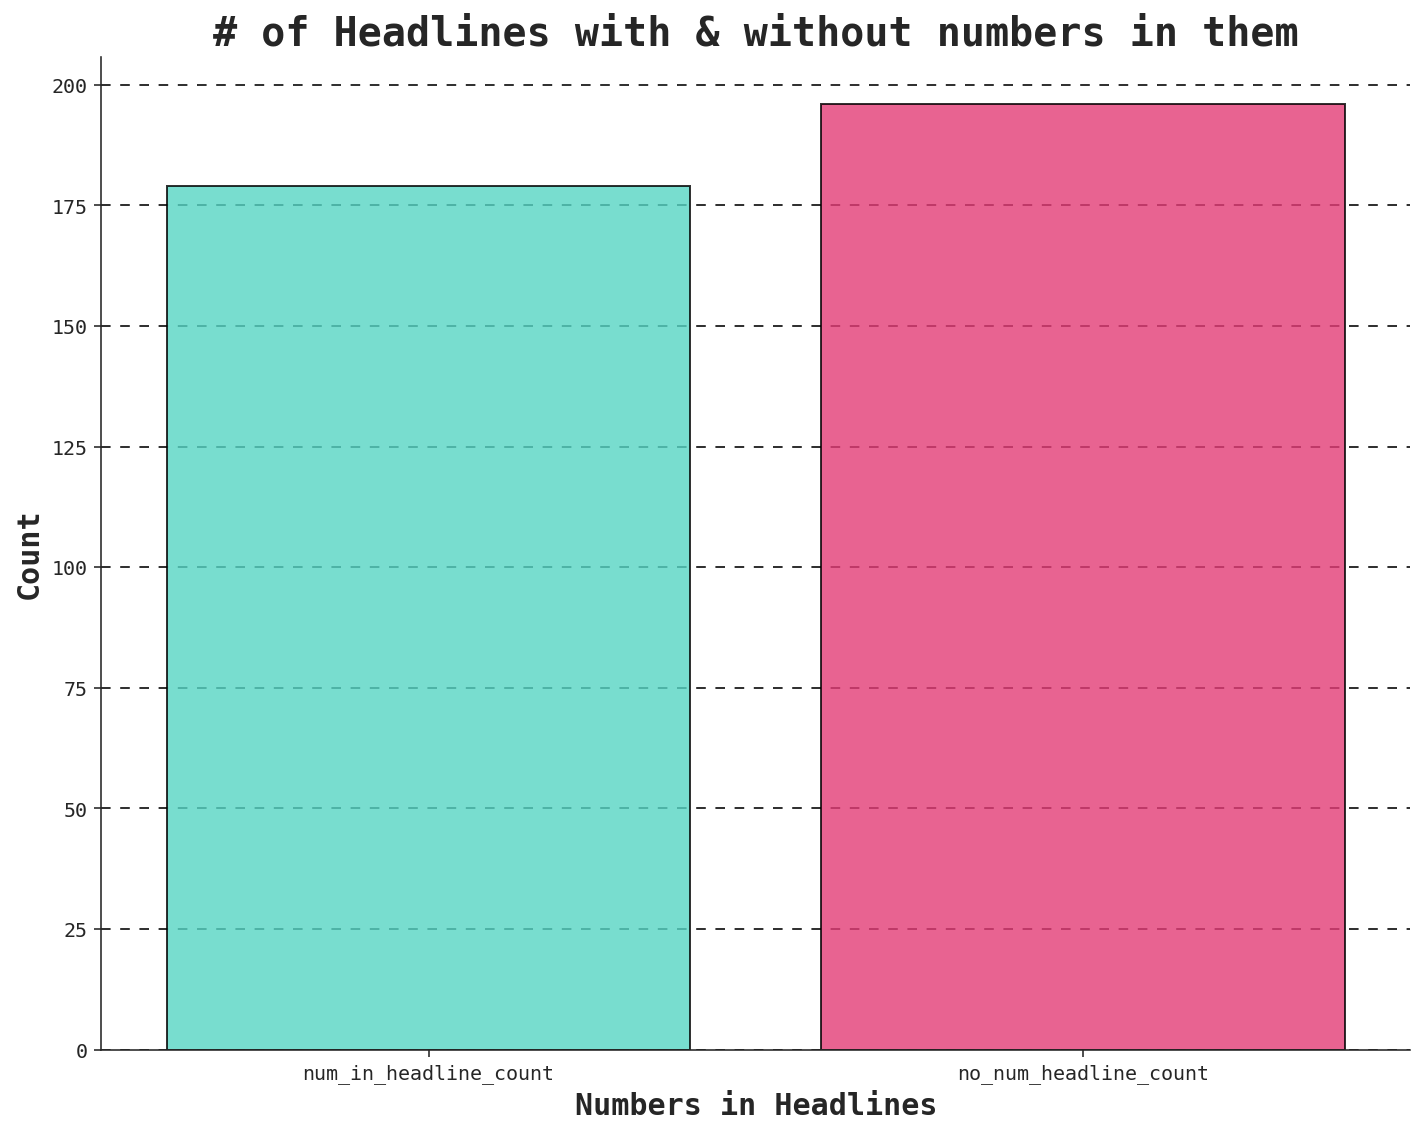

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=headline_numbers, ax=ax, alpha=0.8, zorder=2, palette=colors[-2:], edgecolor='black')
ax.set_title("# of Headlines with & without numbers in them", fontweight='bold', fontsize=20)
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
ax.set_xlabel("Numbers in Headlines", fontweight='bold', fontsize=15)
ax.set_ylabel("Count", fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show();

My guess would have been that there were more headlines with numbers in them than without, but as we can see the headlines are relatively balanced when it comes to titles containing numbers. Even more surprisingly, headlines without numbers have the slight edge over headlines that include digits.

For simplicity sake, let's cut down our data so that it just includes our title text and our text length. We can come back later and do some analysis on the `content` and `description` features of our original dataset, but for now it will be easier to just work with our necessary features.

In [18]:
title_df = data[['title', 'title_len']]
title_df.sample(5)

,title,title_len
131,15 things entitled customers do that signal se...,111
76,20 sci-fi novel adaptations that were even bet...,63
75,"""romy and michele"" musical star says she was f...",120
172,adele recalled feeling ashamed during her divo...,110
308,17 times musicians were decent human beings an...,98


Remove stopwords from the titles and then we'll make a quick wordcloud to visualize popular words before we fully clean the text for other NLP analysis.

In [19]:
title_df['clean_title'] = title_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [20]:
title_df.sample(5)

,title,title_len,clean_title
330,"skeet ulrich admitted that he didn't know ""scr...",91,"skeet ulrich admitted know ""scream"" comedy sta..."
346,have you been treated differently at work beca...,69,treated differently work disability?
7,people are sharing the one food that gives awa...,107,"people sharing one food gives away from, bet c..."
60,24 jobs that people claim only a total asshole...,55,24 jobs people claim total asshole would
277,if you just buy these 30 reviewer-loved produc...,105,"buy 30 reviewer-loved products already, maybe ..."


In [22]:
clean_title_vals = title_df['clean_title'].values
print(clean_title_vals)

['wake "the great resignation", aussies sharing reasons they\'ve left jobs'
 'people sharing paranormal thing ever happened them, reading can’t sleep'
 '15 celebrity couples unexpected still keep night'
 '19 "squid game" behind-the-scenes facts super interesting'
 'netflix announced they\'ve cast uncle iroh firelord ozai "avatar: last airbender" can\'t stop screaming excitement'
 "wonho read internet's thirstiest tweets gave us peek abs"
 'a$ap rocky stopped show demanded fallen fans picked resurfaced video'
 "people sharing one food gives away from, bet can't get right"
 '22 self-care products parents want treat'
 "35 bad parents zero excuses toxic things they've said done children years"
 '14 times detective rosa diaz "brooklyn nine-nine" bisexual legend'
 'what’s like never relationship?'
 "here's anya taylor-joy jell-o wrestling tigger onesie emmy awards"
 '26 things people said children mind-blowing, astonishing, 100% fake'
 '21 celebrity couples made marriages work 20 years 15 ma

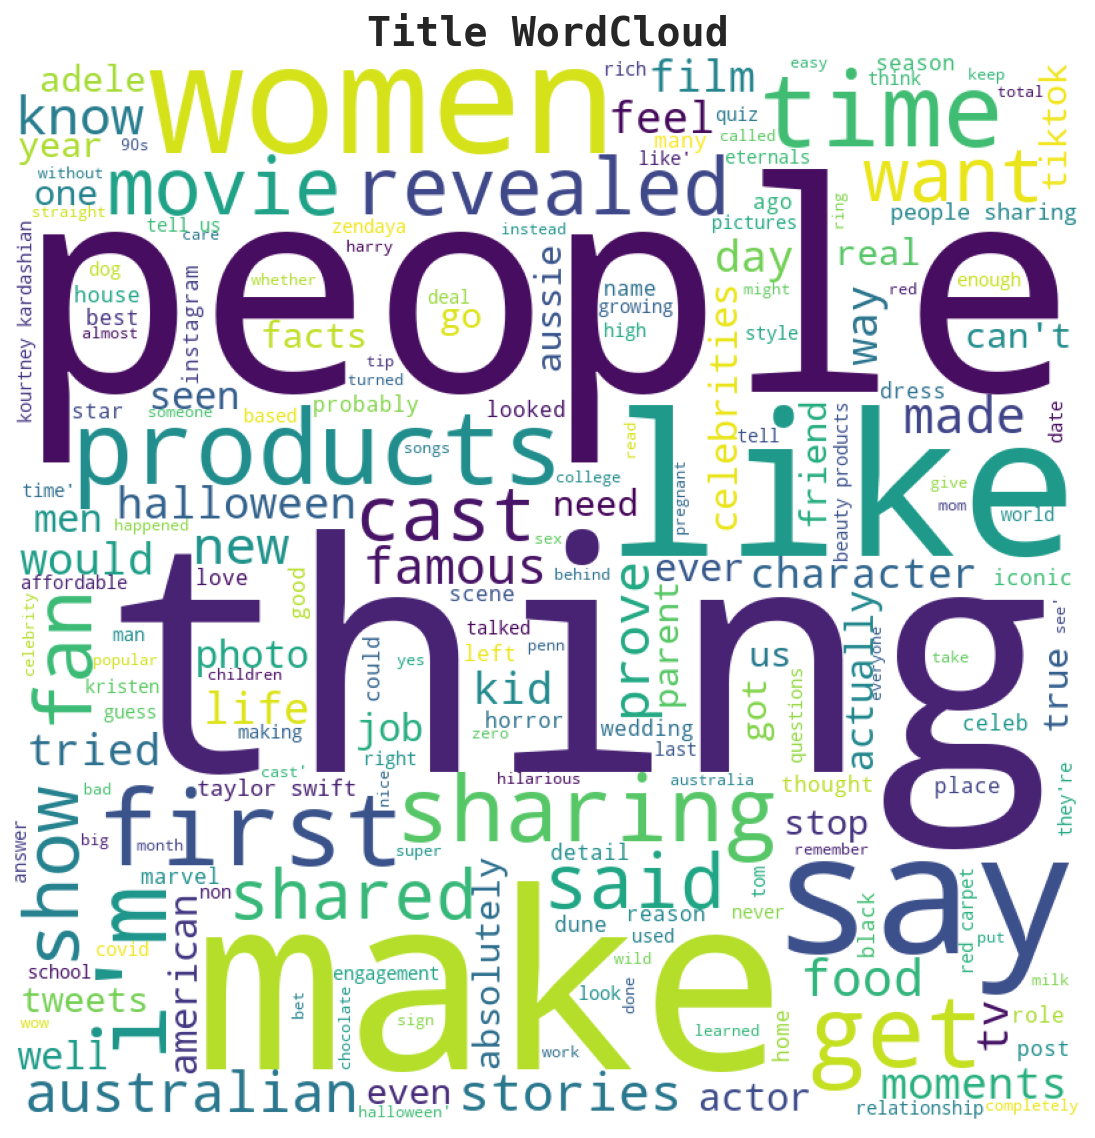

In [23]:
clean_title_vals = title_df['clean_title'].values

title_wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stop_words,
                      min_font_size=8).generate(str(clean_title_vals))

plt.figure(figsize=(10, 8))
plt.imshow(title_wordcloud)
plt.title("Title WordCloud", size=20, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show();

Basically the 3 most popular words that BuzzFeed uses in their headlines are "thing", "people", and "make". We don't need to know the context in which they use them just yet, but let's see if these 3 popular words translate into what their top n-gram combinations are...

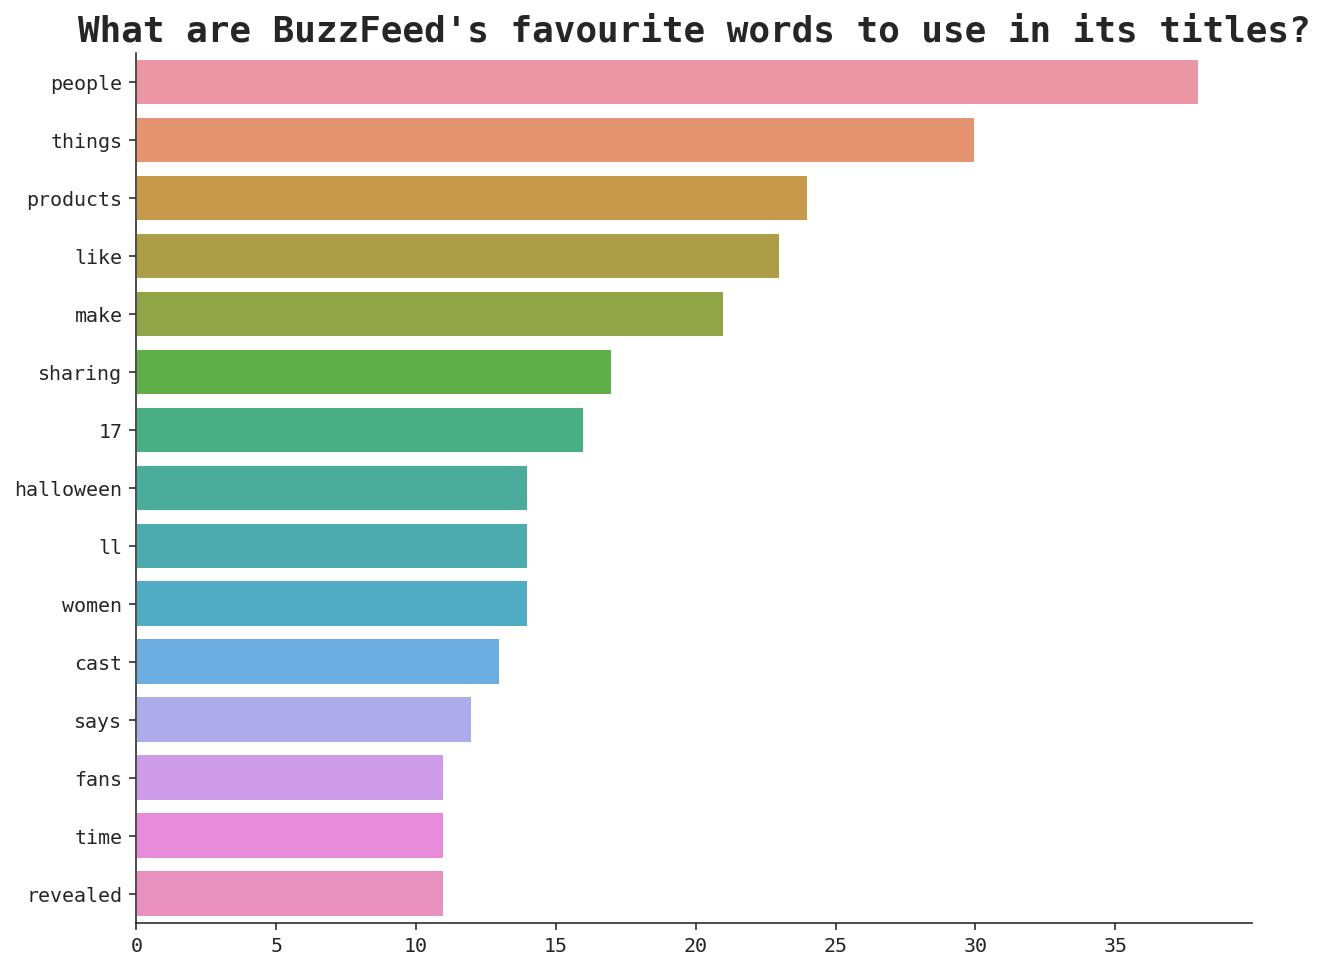

In [24]:
# n-gram visualizations

def get_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

top_n_unigrams = get_ngrams(title_df['clean_title'], 1)
x, y = map(list, zip(*top_n_unigrams))
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x)
plt.title("What are BuzzFeed's favourite words to use in its titles?", size=18, fontweight='bold')
plt.show();

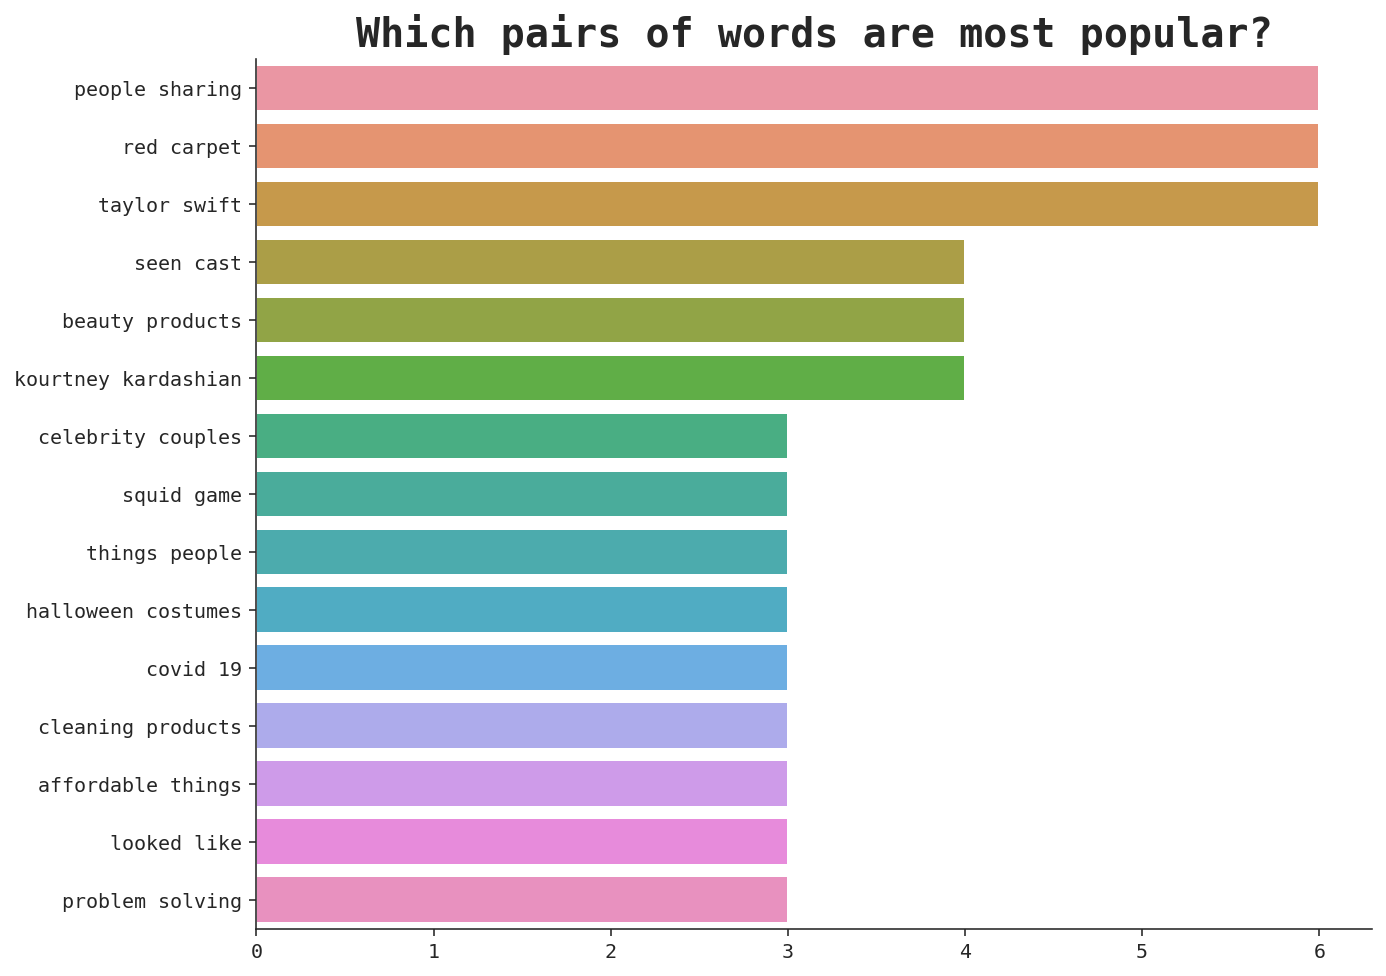

In [25]:
top_n_bigrams = get_ngrams(title_df['clean_title'], 2)
x, y = map(list, zip(*top_n_bigrams))
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x)
plt.title("Which pairs of words are most popular?", size=20, fontweight='bold')
plt.show();

These pairings of words are a bit funny based off the time that they were collected in. We can obviously pick out which sort of topics BuzzFeed was covering at the time of scraping: Taylor Swift was re-releasing another album, there was obviously some sort of Kardashian drama going on, and it was around October that I collected the headlines.

We'll move on and start to do a bit of topic modeling with a cool library called `pyLDAvis`. First we'll process the text data a little bit more so the new topic modeling library can handle what we throw at it. We'll create a new function that will wrap all of our cleaning techniques into one:

In [26]:
def preprocess(df):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for headline in title_df['clean_title']:
        words = [w for w in word_tokenize(headline) if (w not in stop_words)]
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus = preprocess(title_df)

In [27]:
# create a Bag-of-Words model using gensim
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [28]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=3,
                                       id2word=dic,
                                       passes=10,
                                       workers=2,
                                       random_state=2021)
lda_model.show_topics()

[(0,
  '0.013*"thing" + 0.009*"product" + 0.007*"people" + 0.007*"make" + 0.006*"time" + 0.005*"say" + 0.005*"halloween" + 0.005*"like" + 0.005*"first" + 0.005*"fan"'),
 (1,
  '0.010*"people" + 0.006*"australian" + 0.006*"cast" + 0.006*"product" + 0.005*"woman" + 0.005*"sharing" + 0.005*"red" + 0.005*"men" + 0.005*"character" + 0.004*"story"'),
 (2,
  '0.008*"like" + 0.008*"movie" + 0.007*"people" + 0.006*"thing" + 0.005*"said" + 0.005*"tried" + 0.004*"life" + 0.004*"want" + 0.004*"tell" + 0.004*"feel"')]

In [29]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
pyLDAvis.display(vis)

/Users/jordansamek/opt/miniconda3/envs/baseline_env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jordansamek/opt/miniconda3/envs/baseline_env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jordansamek/opt/miniconda3/envs/baseline_env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jordansamek/opt/miniconda3/envs/baseline_env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
 

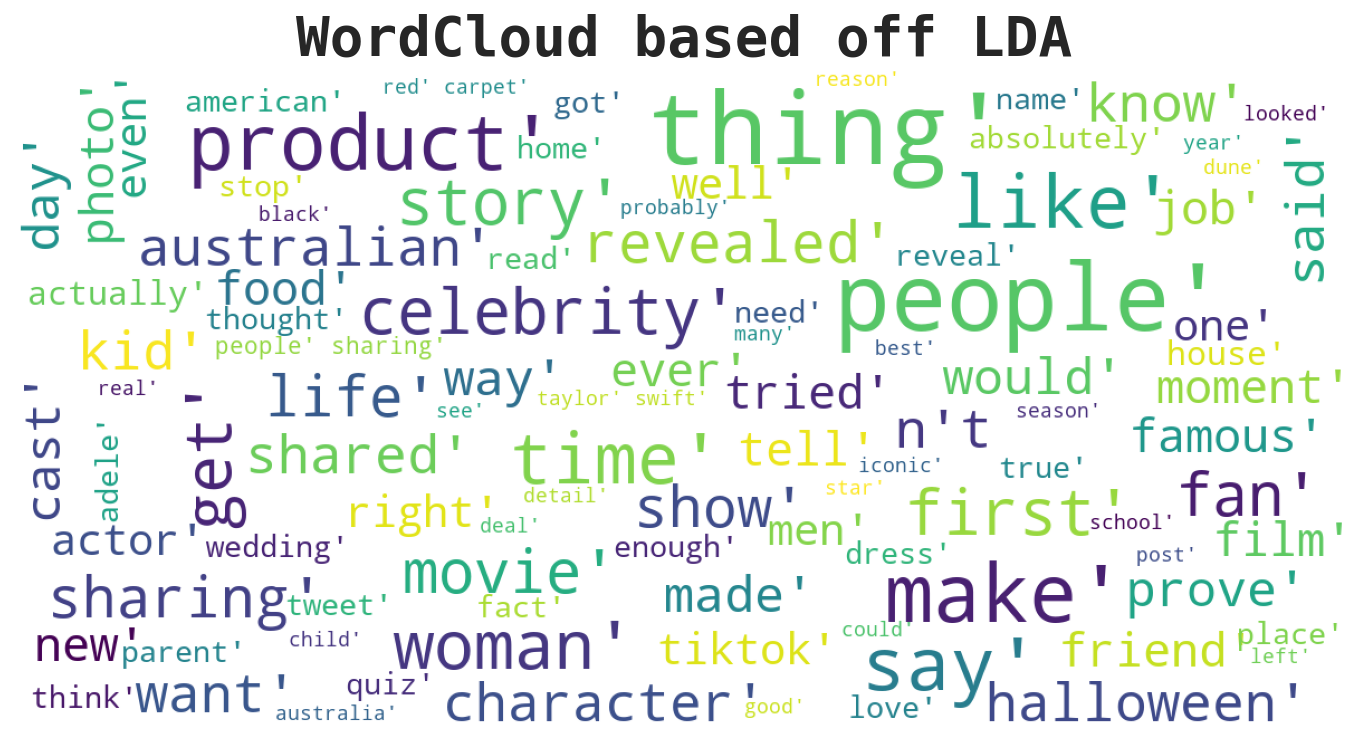

In [30]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=42
    )
    wordcloud = wordcloud.generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title("WordCloud based off LDA", size=28, fontweight='bold')
    plt.show();
    
show_wordcloud(corpus)

Moving on to use the TextBlob library to calculate the polarity and sentiment of the headlines.

In [31]:
from textblob import TextBlob

In [32]:
def polarity(text):
    # calculating polarity scores of our headlines
    # will give a score between -1.0 and 1.0
    return TextBlob(text).sentiment.polarity

title_df['polarity_score'] = title_df['title'].apply(lambda x: polarity(x))

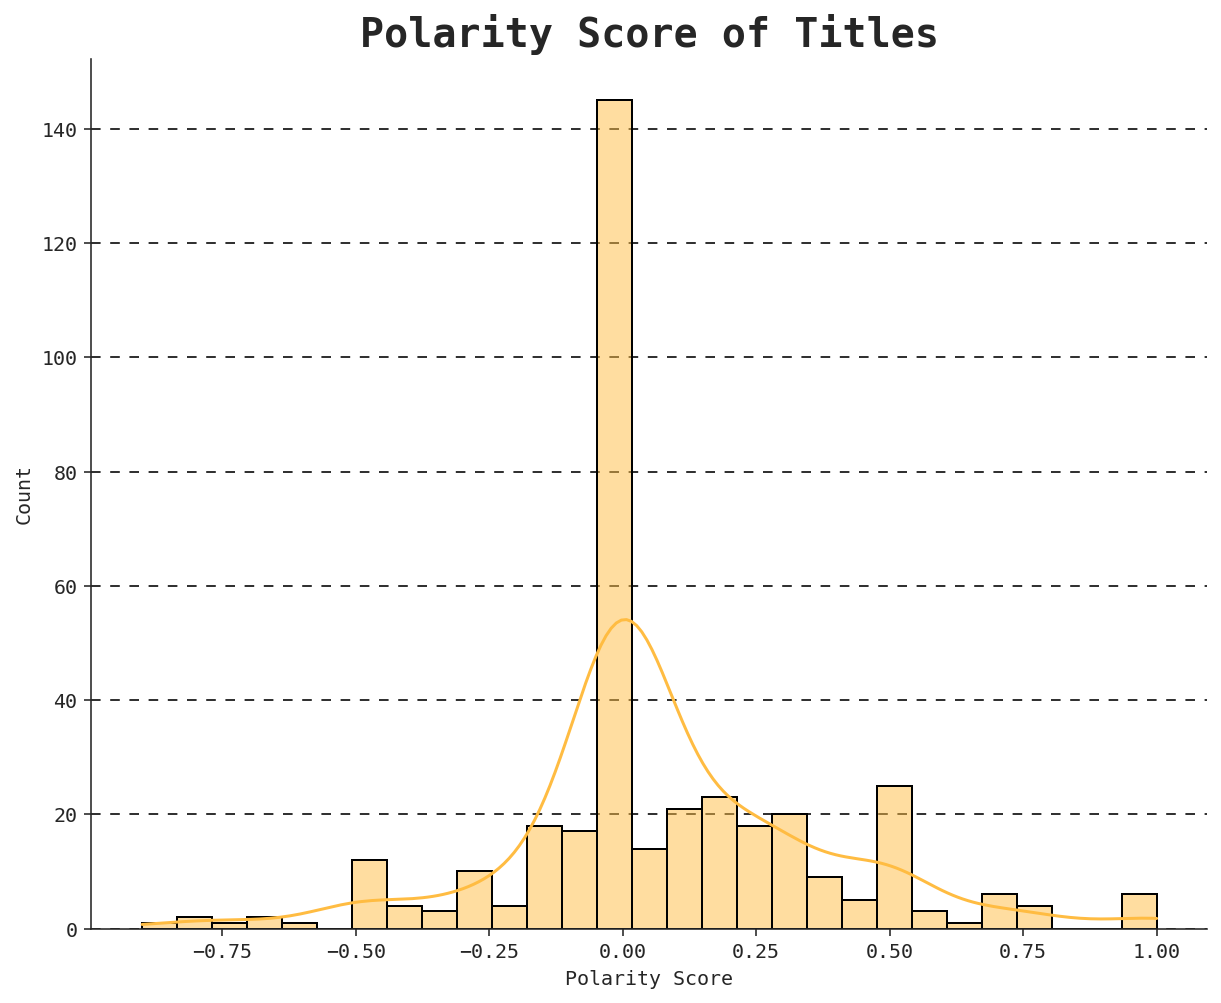

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(title_df.polarity_score, kde=True, color=colors[2], edgecolor='black', ax=ax)
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
ax.set_title("Polarity Score of Titles", size=20, fontweight='bold')
ax.set_xlabel("Polarity Score")
plt.show();

In [34]:
title_df['polarity_score'].describe()

count    375.000000
mean       0.080801
std        0.293788
min       -0.900000
25%        0.000000
50%        0.000000
75%        0.240179
max        1.000000
Name: polarity_score, dtype: float64

We can see that our mean polarity score is around 0.08 which is a very low score, meaning that our headlines, on average, are quite neutral and maybe even slightly more positive in their sentiment. BuzzFeed isn't generally a news outlet that gets too political, but we can also note that my period of collection of the headlines wasn't any significant point in time so there shouldn't be many polarizing topics unless BuzzFeed editors are feeling frisky. We'll have a better conclusion once we calculate the sentiments and visualize them.

So we've got polarity scores to quantitatively show what our headlines are like, but let's classify those scores as either positive, negative or neutral sentiment. We'll do this by creating a function that specifies a threshold, and if the scores are above, below, or equal to the threshold then we bin them into their corresponding category.

In [35]:
def sentiment(x):
    if x < 0:
        return 'negative'
    elif x == 0:
        return 'neutral'
    else:
        return 'positive'
    
title_df['sentiment'] = title_df['polarity_score'].apply(lambda x: sentiment(x))

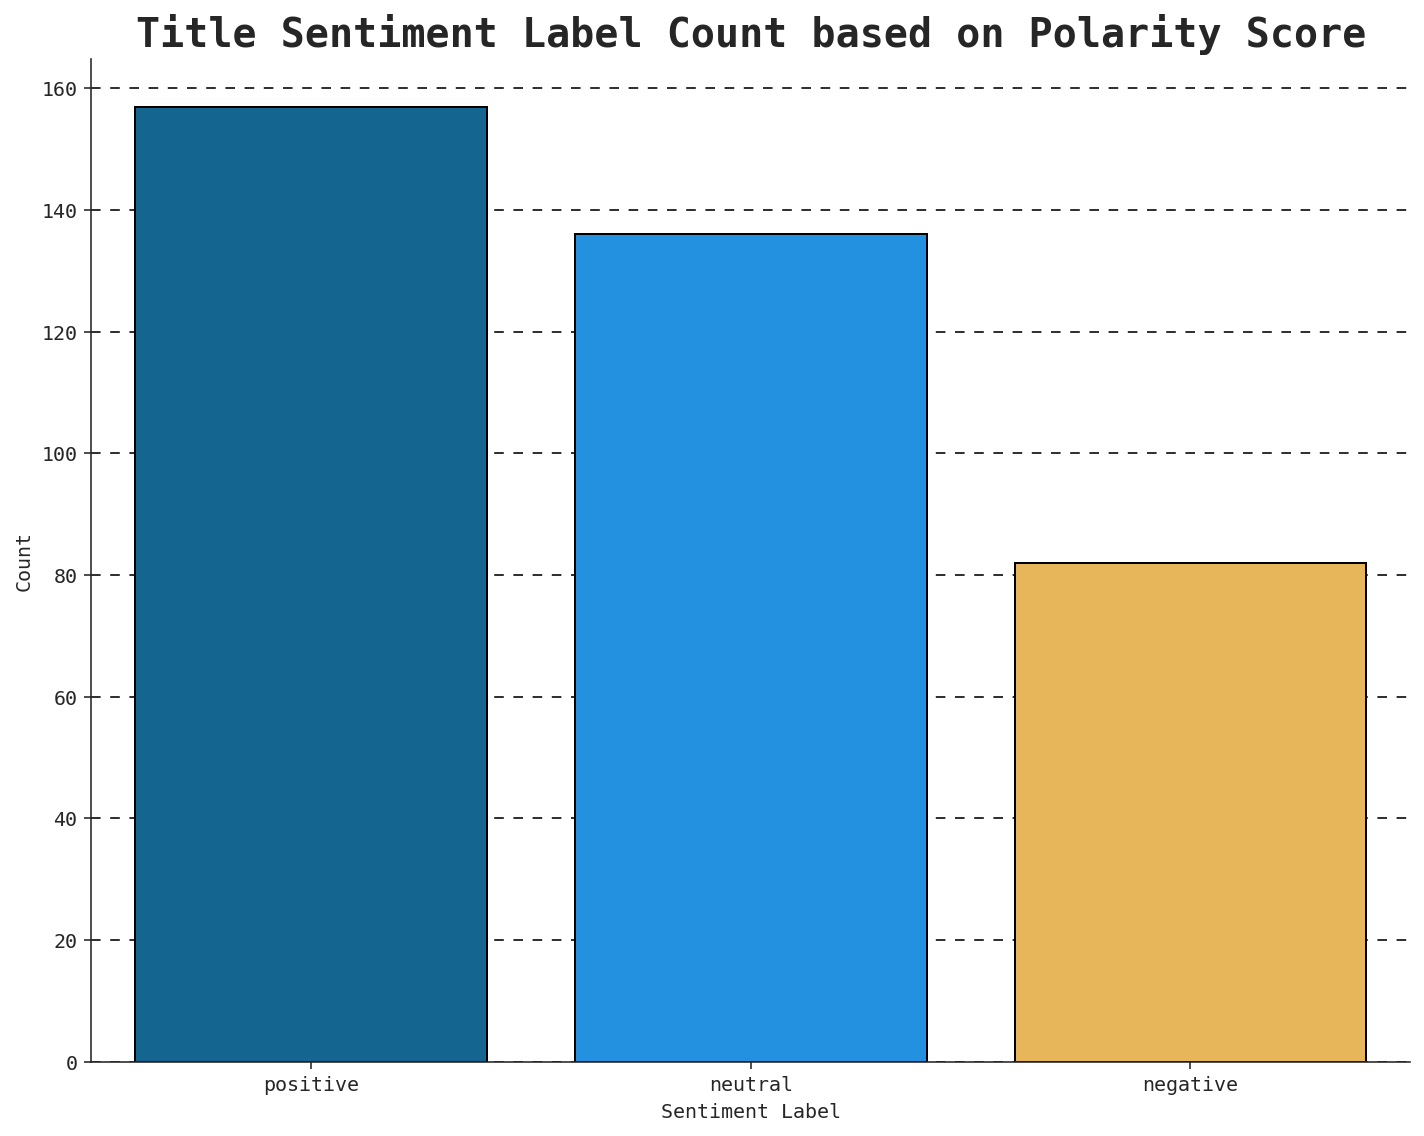

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(title_df.sentiment.value_counts().index,
            title_df.sentiment.value_counts(), edgecolor='black')
ax.set_title("Title Sentiment Label Count based on Polarity Score", size=20, fontweight='bold')
ax.set_xlabel("Sentiment Label")
ax.set_ylabel("Count")
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
plt.tight_layout()
plt.show();

In [37]:
pct_sent = round((title_df.sentiment.value_counts() / (len(title_df)))*100, 2)
print(pct_sent)

positive    41.87
neutral     36.27
negative    21.87
Name: sentiment, dtype: float64


Let's take a look at a few headlines from each sentiment category...

In [38]:
pos_headlines = title_df[title_df['sentiment'] == 'positive']['title']
print(pos_headlines.sample(3).tolist())

["i'm applauding these 18 famous women who called out hollywood for the way it depicts women on screen", 'tell me about your favorite foreign film on netflix', '71 brilliant details from "community" that should\'ve won an emmy for "best attention to detail in a comedy series"']


In [39]:
neu_headlines = title_df[title_df['sentiment'] == 'neutral']['title']
print(neu_headlines.sample(3).tolist())

["27 stories about how people discovered their mom or dad's infidelity that have left me speechless", 'if your closet is a disaster zone, these 34 organization products can help', "here's how australians react when they spot a kangaroo in their front yard"]


In [40]:
neg_headlines = title_df[title_df['sentiment'] == 'negative']['title']
print(neg_headlines.sample(3).tolist())

['carole baskin of "tiger king" revealed what she thinks happened to her missing husband in a reddit ama', '14 horrible bosses who probably faked their way to the top', "14 thanksgiving fails i wouldn't even wish upon my worst enemy"]


We see some interesting headlines when we print out the results. Some even don't make sense being in the category that they're in. This could be due to the fact that some sentiment analysis techniques/libraries aren't great at detecting negative sentiments. One library that works pretty well at detecting negative sentiments is the VADER library. We can import it via `nltk` and work from there.

In [41]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def vader_score(sent):
    ss = sia.polarity_scores(sent)
    
    return np.argmax(list(ss.values())[::-1])

title_df['polarity'] = title_df['title'].apply(lambda x: vader_score(x))
polarity = title_df['polarity'].replace({0:'neg', 2:'neu', 3:'pos'})

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jordansamek/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


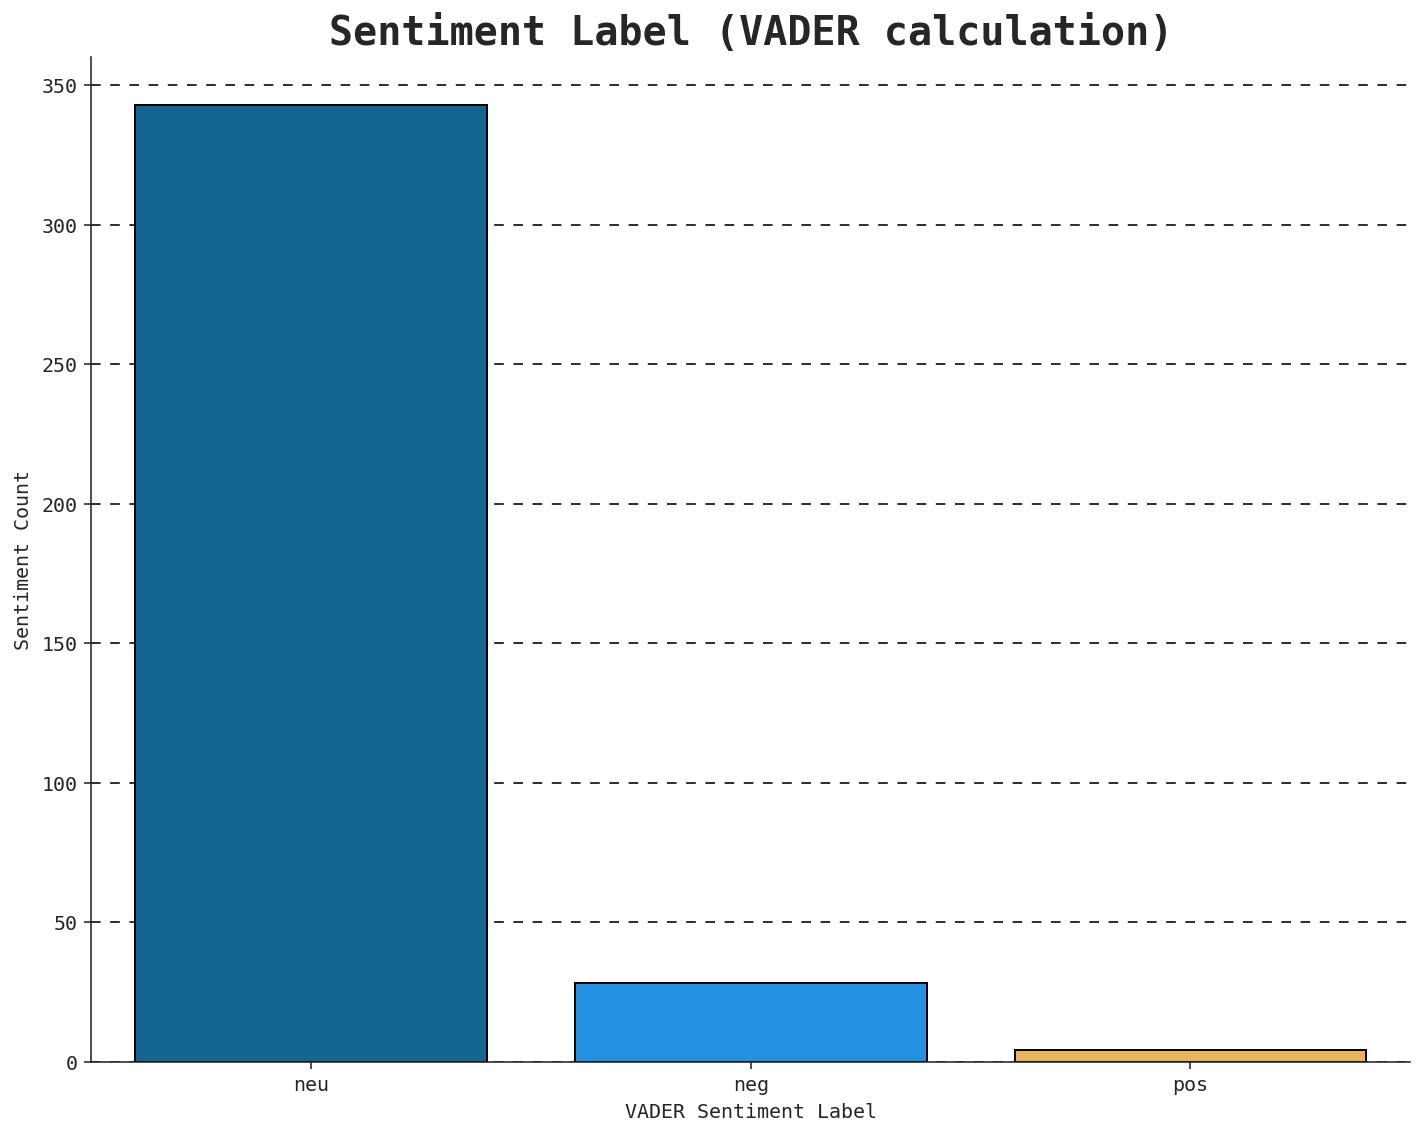

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(polarity.value_counts().index,
            polarity.value_counts(), edgecolor='black')
ax.set_title("Sentiment Label (VADER calculation)", size=20, fontweight='bold')
ax.set_xlabel("VADER Sentiment Label")
ax.set_ylabel("Sentiment Count")
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
plt.tight_layout()
plt.show();

In [43]:
title_df['polarity'].value_counts()

2    343
0     28
3      4
Name: polarity, dtype: int64

In [44]:
title_df['polarity'].describe()

count    375.000000
mean       1.861333
std        0.539333
min        0.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: polarity, dtype: float64

In [46]:
def vader_sentiment(score):
    emotion = ""
    if score == 2.0:
        return "neutral"
    elif score == 3.0:
        return "positive"
    else:
        return "negative"

In [47]:
title_df['vader_sentiment'] = title_df['polarity'].apply(lambda x: vader_sentiment(x))
title_df['vader_sentiment'].value_counts()

neutral     343
negative     28
positive      4
Name: vader_sentiment, dtype: int64

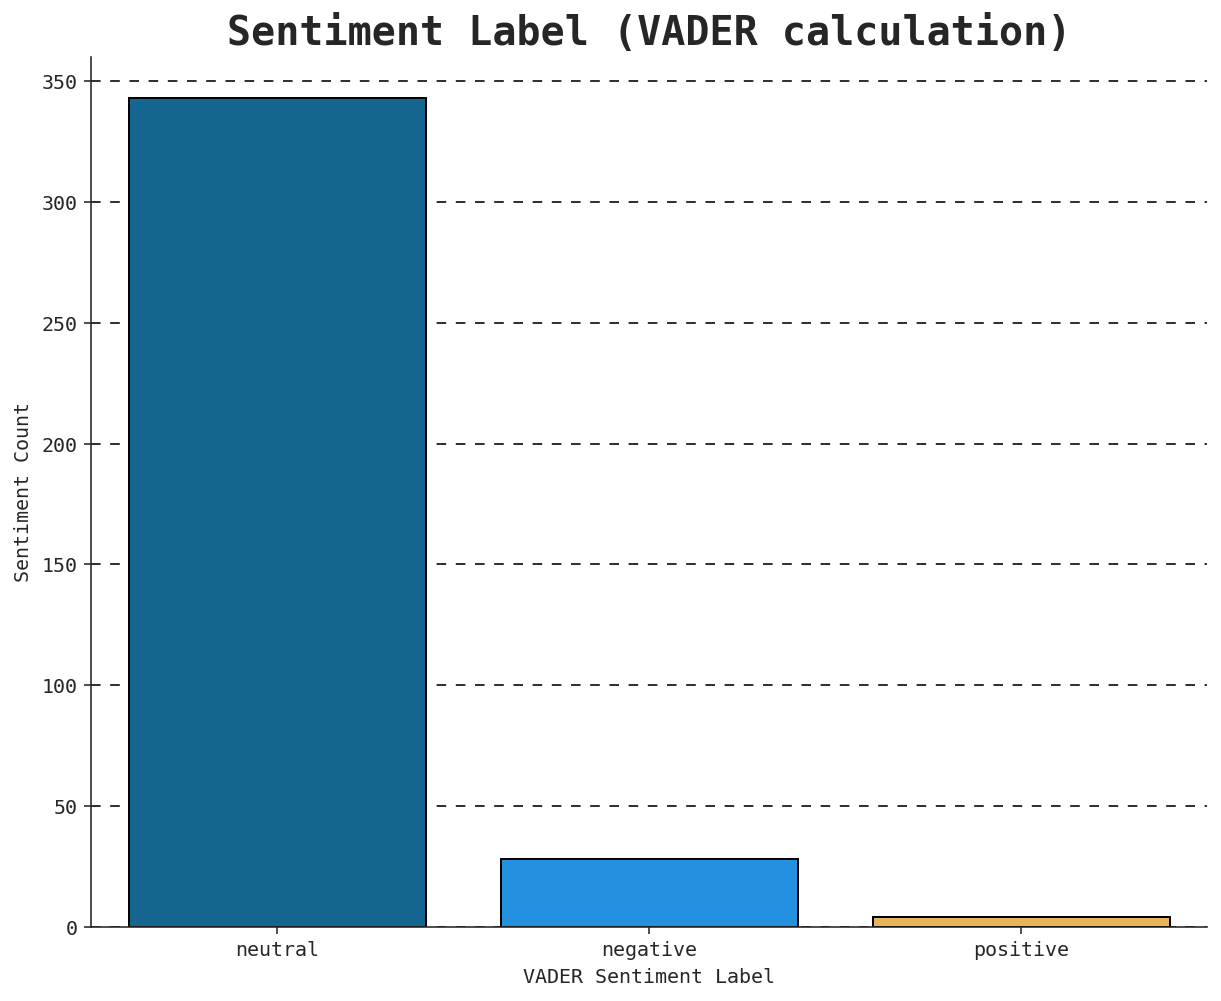

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(title_df['vader_sentiment'].value_counts().index,
            title_df['vader_sentiment'].value_counts(), edgecolor='black')
ax.set_title("Sentiment Label (VADER calculation)", size=20, fontweight='bold')
ax.set_xlabel("VADER Sentiment Label")
ax.set_ylabel("Sentiment Count")
ax.grid(color='black', linestyle=':', axis='y', zorder=0, dashes=(6, 6))
plt.show();

Visualize NER with SpaCy

In [49]:
# hide
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 3.1 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [62]:
import spacy
from spacy import displacy
# from IPython.core.display import display, HTML

rand_title = np.random.randint(0, 381)
text = title_df['title'][rand_title]
# print(text)

nlp = spacy.load('en_core_web_sm')
doc = nlp(text)

# html = displacy.render(doc, style='ent', jupyter=True)
# display(HTML(html))

displacy.render(doc, style='ent')

I've run the above code multiple times and it seems like the visualizer doesn't pick up on some basic names. For now we'll move along. What we can do that might be useful is to apply NER on our headlines and then store the entity types.

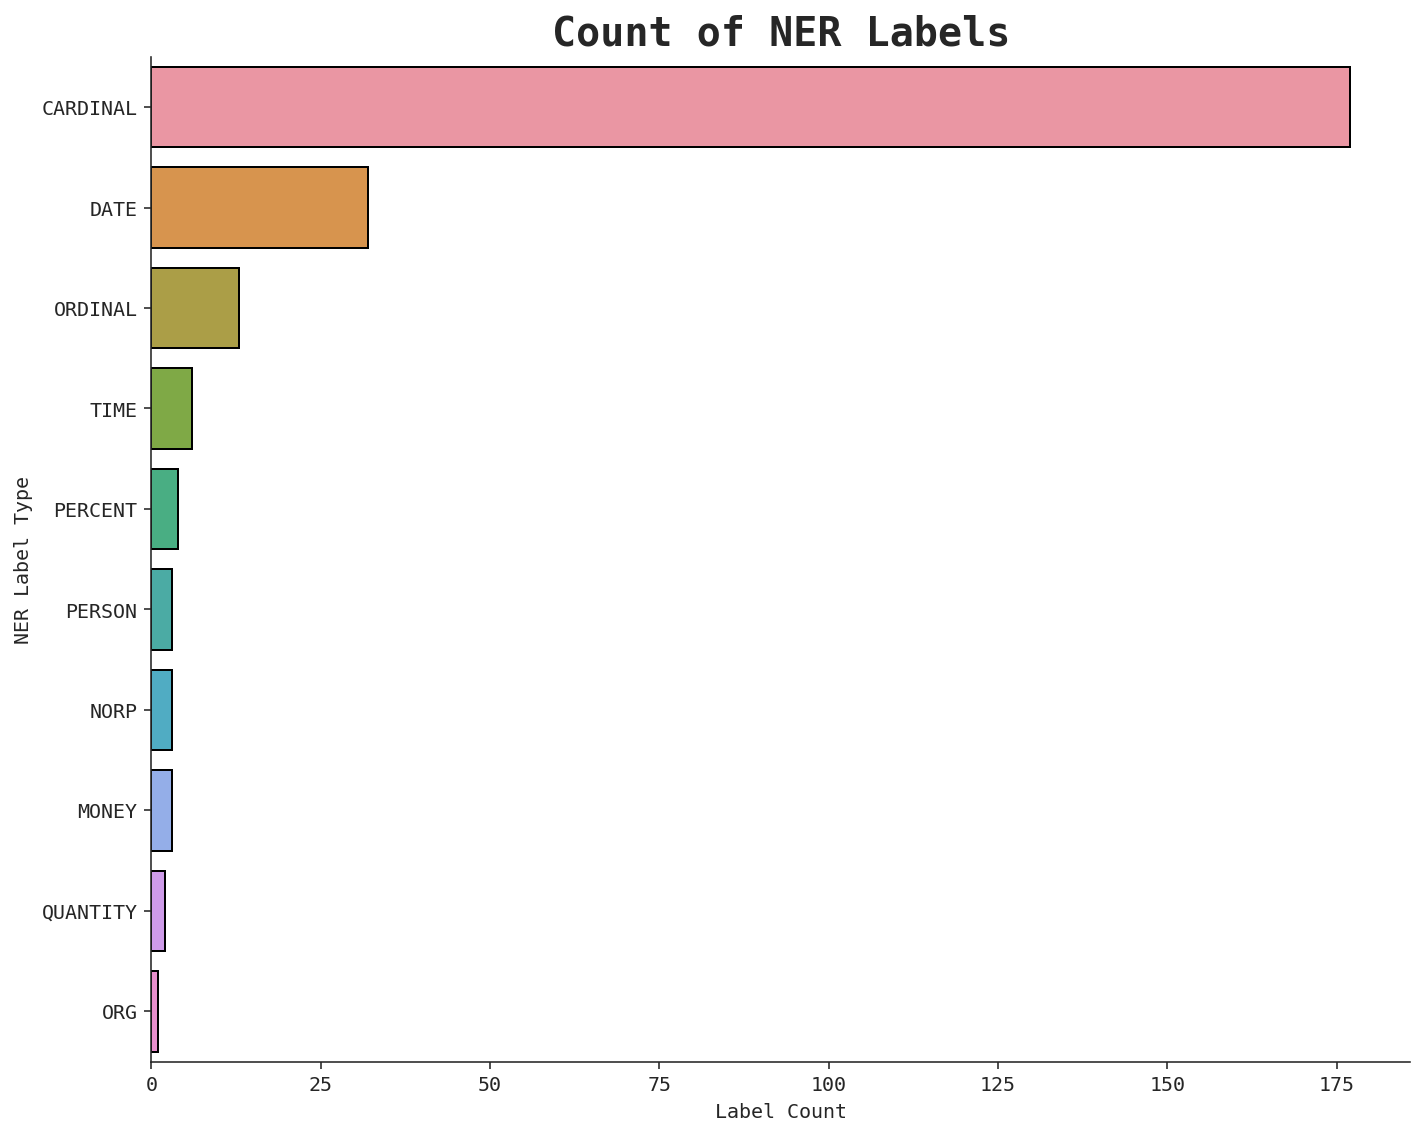

In [63]:
from collections import Counter

def ner_types(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = title_df['title'].apply(lambda x: ner_types(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

fig, ax = plt.subplots(figsize=(10, 8))
x, y = map(list, zip(*count))
sns.barplot(x=y, y=x, edgecolor='black')
ax.set_title("Count of NER Labels", size=20, fontweight='bold')
ax.set_xlabel("Label Count")
ax.set_ylabel("NER Label Type")
plt.tight_layout()
plt.show();

After the NER graph, I think it's clear even from our own observations that BuzzFeed loves numbers in their headlines.

In [64]:
title_df.head()

,title,title_len,clean_title,polarity_score,sentiment,polarity,vader_sentiment
0,"in the wake of ""the great resignation"", aussie...",89,"wake ""the great resignation"", aussies sharing ...",0.400000,positive,0,negative
1,people are sharing the most paranormal thing t...,114,people sharing paranormal thing ever happened ...,0.500000,positive,2,neutral
2,15 celebrity couples that were so unexpected t...,75,15 celebrity couples unexpected still keep night,0.100000,positive,2,neutral
3,"19 ""squid game"" behind-the-scenes facts that a...",66,"19 ""squid game"" behind-the-scenes facts super ...",0.144444,positive,0,negative
4,netflix have announced who they've cast for un...,145,netflix announced they've cast uncle iroh fire...,0.000000,neutral,0,negative


Let's create a stripped down dataset for our deep learning models to come...

In [65]:
model_df = title_df[['clean_title']]
model_df.to_csv('../data/clean_titles.csv', index=False)